In [1]:
import transformers
import accelerate
from datasets import load_dataset
import peft

/Users/rishabhshah/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.35.2
Accelerate version: 0.25.0
PEFT version: 0.6.2


In [3]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
dataset = load_dataset("food101", split="train[:5000]")

labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label[2])

Generating validation split: 100%|██████████| 25250/25250 [00:19<00:00, 1328.94 examples/s]

baklava


In [4]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)


config.json: 100%|██████████| 502/502 [00:00<00:00, 878kB/s]


In [5]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [6]:
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [7]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [8]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [9]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
print_trainable_parameters(model)

pytorch_model.bin: 100%|██████████| 346M/346M [00:04<00:00, 69.2MB/s] 
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


In [10]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 667493 || all params: 86543818 || trainable%: 0.77


'trainable params: 667493 || all params: 86466149 || trainable%: 0.77'

In [12]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    # fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

In [14]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [37]:
import torch

def collate_fn(examples):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        x = torch.ones(1, device=mps_device)
        print (x)
    else:
        print ("MPS device not found.")
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples], device=mps_device)
    return {"pixel_values": pixel_values, "labels": labels}

In [38]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

  0%|          | 0/45 [07:07<?, ?it/s]


tensor([1.], device='mps:0')
tensor([1.], device='mps:0')


RuntimeError: MPS backend out of memory (MPS allocated: 7.07 GB, other allocations: 11.24 GB, max allowed: 18.13 GB). Tried to allocate 295.50 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [39]:
trainer.evaluate(val_ds)
{
    "eval_loss": 0.14475855231285095,
    "eval_accuracy": 0.96,
    "eval_runtime": 3.5725,
    "eval_samples_per_second": 139.958,
    "eval_steps_per_second": 1.12,
    "epoch": 5.0,
}

tensor([1.], device='mps:0')
tensor([1.], device='mps:0')


RuntimeError: MPS backend out of memory (MPS allocated: 7.57 GB, other allocations: 10.50 GB, max allowed: 18.13 GB). Tried to allocate 73.88 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [43]:
repo_name = f"rishabhshah/{model_name}-finetuned-lora-food101"
lora_model.push_to_hub(repo_name)







adapter_model.safetensors: 100%|██████████| 2.68M/2.68M [00:00<00:00, 6.02MB/s]


CommitInfo(commit_url='https://huggingface.co/rishabhshah/vit-base-patch16-224-in21k-finetuned-lora-food101/commit/5b5cf94ef747c5ad7c3b219638ebf6dd443e0fc6', commit_message='Upload model', commit_description='', oid='5b5cf94ef747c5ad7c3b219638ebf6dd443e0fc6', pr_url=None, pr_revision=None, pr_num=None)

In [44]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, repo_name)



adapter_config.json: 100%|██████████| 624/624 [00:00<00:00, 273kB/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors: 100%|██████████| 2.68M/2.68M [00:00<00:00, 31.6MB/s]


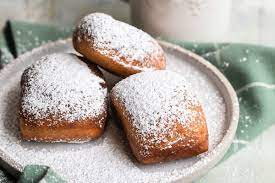

In [45]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [46]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

OSError: rishabhshah/vit-base-patch16-224-in21k-finetuned-lora-food101 does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co/rishabhshah/vit-base-patch16-224-in21k-finetuned-lora-food101/main' for available files.